In [1]:
import pandas as pd
import numpy as np

import string
import io
import nltk

from nltk.corpus import stopwords
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import PorterStemmer
import math
import re
import seaborn as sns
import tensorflow as tf
from copy import copy, deepcopy
from unicodedata import normalize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from numpy import asarray


In [18]:
file = open('spa.txt',encoding='utf-8').read().split('\n')
lines = file[0:7500] ## Increase this number to 50000 for a better Bleu score. Due to limitations of hardware resources, 
##i have kept it 7500
print(len(lines))
print(lines[100])

7500
Really?	¿En serio?	CC-BY 2.0 (France) Attribution: tatoeba.org #373216 (kotobaboke) & #344138 (tatoerique)


In [19]:
def My_train_test_split(df,df2,train_percent, test_percent):
    # calculate random permutation of indices
    m = len(df)
    perm = np.random.permutation(m)
    train_end = int(train_percent * m)
    test_end = int(test_percent * m) + train_end
    
    Xtrain = [df[i] for i in perm[:train_end]]
    Xtest = [df[i] for i in perm[train_end:test_end]]
    
    Ytrain = [df2[i] for i in perm[:train_end]]
    Ytest = [df2[i] for i in perm[train_end:test_end]]
    return(Xtrain, Xtest, Ytrain,Ytest,)  
  
def clean_pairs(lines):
  cleaned = list()
  # prepare regex for char filtering
  re_print = re.compile('[^%s]' % re.escape(string.printable))
  # prepare translation table for removing punctuation
  table = str.maketrans('', '', string.punctuation)
  for pair in lines:
    clean_pair = list()
    for line in pair:
      # rmove word characters.
      line = normalize('NFD', line).encode('ascii', 'ignore')
      line = line.decode('UTF-8')
      # tokenize on white space
      line = line.split()
      # convert to lowercase
      line = [word.lower() for word in line]
      # remove punctuation from each token
      line = [word.translate(table) for word in line]
      # remove non-printable chars form each token
      line = [w.strip() for w in line]
      # remove tokens with numbers in them
      line = [word for word in line if word.isalpha()]
      # store as string
      clean_pair.append(' '.join(line))
    cleaned.append(clean_pair)
  return(cleaned)

split = [re.split(r'\t+', item)for item in lines]
split = clean_pairs(split)
X  = [x[0] for x in split]
# add both start and end tokens to denote the end
#of the sentence to the each target line.
Y  = ['START_ ' + x[1] + ' _END'for x in split]

df = pd.DataFrame(
    {'X': X,
     'Y': Y,
    })

# remove duplicates
df = df.drop_duplicates(subset=['X'], keep= 'first')
X = df.X.values
X  = [x.split() for x in X]
Y = df.Y.values
Y  = [y.split() for y in Y]

# split into train an test.
Xtrain,Xtest,Ytrain,Ytest = My_train_test_split(X,Y,0.7, 0.3)

In [20]:
# set of english words 
all_eng_words  = set([item for sublist in X for item in sublist])
# set of spanish words 
all_spa_words = set([item for sublist in Y for item in sublist])

# maximum english sentence length
eng_sentence_length = max([len(sample.split()) for sample in df.X])
# maximum spanish  sentence length
spa_sentence_length = max([len(sample.split()) for sample in df.Y])

input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_spa_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_spa_words)

In [21]:
print('Number of samples:', len(df))
print('Number of unique source language tokens:', len(all_eng_words))
print('Number of unique target language tokens:', len(all_spa_words))
print('Max sequence length of source language:', eng_sentence_length)
print('Max sequence length of target language:', spa_sentence_length)
print("Source Vocabulary",all_eng_words)
print("Target Vocabulary",all_spa_words)

Number of samples: 5183
Number of unique source language tokens: 1872
Number of unique target language tokens: 2895
Max sequence length of source language: 5
Max sequence length of target language: 10
Source Vocabulary {'argue', 'skip', 'left', 'eggs', 'poker', 'healthily', 'about', 'follow', 'recycle', 'groaned', 'then', 'smiling', 'paused', 'gun', 'approved', 'fired', 'smoking', 'needs', 'dating', 'wine', 'terrific', 'guess', 'stand', 'apple', 'also', 'afternoon', 'ran', 'sneeze', 'man', 'coin', 'son', 'enter', 'sexist', 'depressed', 'sick', 'aloof', 'burn', 'spies', 'helps', 'monday', 'dope', 'or', 'smart', 'twin', 'empty', 'part', 'much', 'salesman', 'lift', 'date', 'rules', 'lawyer', 'fought', 'jittery', 'student', 'jealous', 'candy', 'turned', 'abroad', 'resting', 'runs', 'confident', 'command', 'wig', 'full', 'cruel', 'lines', 'finished', 'resist', 'ive', 'restless', 'happy', 'twice', 'acquired', 'hid', 'cooking', 'unlucky', 'up', 'vote', 'forgetful', 'freaky', 'goofed', 'flag',

In [22]:
# dictionary of words whereeach value is a unique integer value
input_token_index = dict(
    [(word, i) for i, word in enumerate(input_words)])
target_token_index = dict(
    [(word, i) for i, word in enumerate(target_words)])

# placeholders training data
encoder_input_data = np.zeros(
    (len(Xtrain), eng_sentence_length),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(Ytrain), spa_sentence_length),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(Ytrain), spa_sentence_length, num_decoder_tokens),
    dtype='float32')

# populate all the placeholders with unique integer values for every word
for i, (input_text, target_text) in enumerate(zip(Xtrain, Ytrain)):
    for t, word in enumerate(input_text):
        encoder_input_data[i, t] = input_token_index[word]
    for t, word in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t] = target_token_index[word]
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[word]] = 1.

# load the Glove file create an index for each word in
# embedding file that represents the embeding vector
embeddings_index = dict()
f = open('glove.6B.100d.txt',encoding='utf-8').readlines()
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs

# create an embedding vector for each value in our unique
# source language.
MAX_NUM_WORDS = 1880
EMBEDDING_DIM = embeddings_index.get('a').shape[0]
num_words = min(MAX_NUM_WORDS, len(all_eng_words)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for i, word in enumerate(list(all_eng_words)):
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word) ## This references the loaded embeddings dictionary
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [23]:
encoder_input_data[3]

array([1673., 1866.,    0.,    0.,    0.], dtype=float32)

In [24]:
#history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,batch_size=128,epochs=100,validation_split=0.05)

## Attention
Attention was presented by Dzmitry Bahdanau, et al. in their paper “Neural Machine Translation by Jointly Learning to Align and Translate” that reads as a natural extension of their previous work on the Encoder-Decoder model.

Attention is proposed as a solution to the limitation of the Encoder-Decoder model encoding the input sequence to one fixed length vector from which to decode each output time step. This issue is believed to be more of a problem when decoding long sequences.

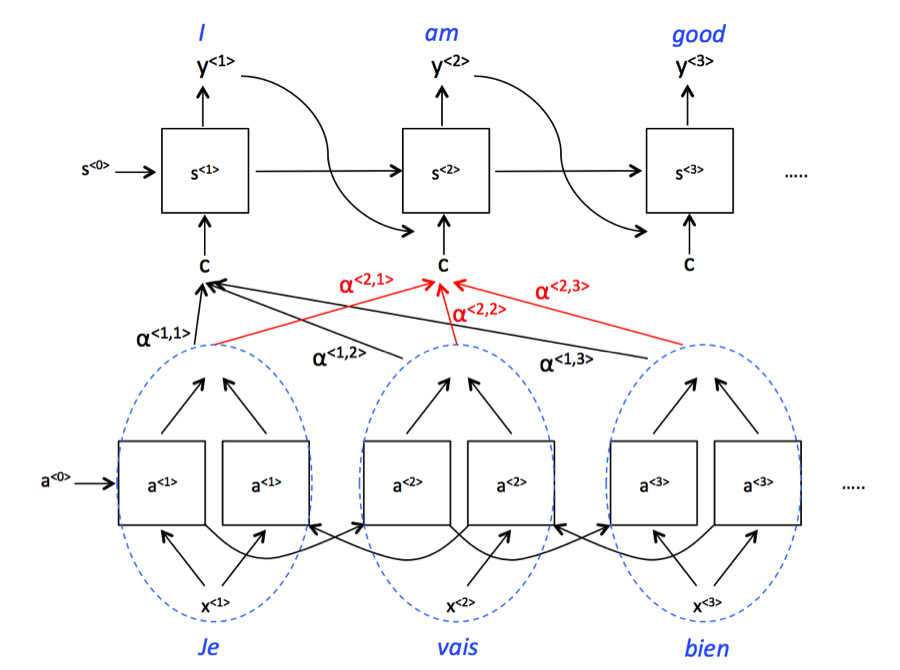

Source: https://machinelearningmastery.com/how-does-attention-work-in-encoder-decoder-recurrent-neural-networks/#:~:text=Attention%20Model,-Attention%20was%20presented&text=Attention%20is%20proposed%20as%20a,problem%20when%20decoding%20long%20sequences.

## Creating Attention

---



In [29]:
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Activation, dot, concatenate
from tensorflow.keras.layers import Input, Embedding, LSTM, TimeDistributed, Dense
from tensorflow.keras.models import Model

embedding_size = 100
Encoder_Input = Input(shape=(eng_sentence_length,))
encoder = Embedding(1873, 100, weights= [embedding_matrix], trainable=False)(Encoder_Input)
encoder = LSTM(64, return_sequences=True, unroll=True)(encoder)
encoder_last = encoder[:,-1,:]

Decoder_Input = Input(shape=(spa_sentence_length,))
decoder = Embedding(num_decoder_tokens, embedding_size)(Decoder_Input)
decoder = LSTM(64, return_sequences=True, unroll=True)(decoder, initial_state=[encoder_last, encoder_last])

# Global Attention with Dot-based scoring function 
attention = dot([decoder, encoder], axes=[2, 2])
attention = Activation('softmax', name='attention')(attention)

context = dot([attention, encoder], axes=[2,1])

decoder_combined_context = concatenate([context, decoder])

output = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
output = TimeDistributed(Dense(num_decoder_tokens, activation="softmax"))(output)

model = Model(inputs =[Encoder_Input, Decoder_Input], outputs =[output])
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 5)]          0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 5, 100)       187300      input_12[0][0]                   
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
lstm_6 (LSTM)                   (None, 5, 64)        42240       embedding_11[0][0]               
____________________________________________________________________________________________

In [30]:
history = model.fit([encoder_input_data, decoder_input_data],
          [decoder_target_data] ,verbose=1, batch_size=32,
          epochs=100, validation_split=0.05)

Train on 3446 samples, validate on 182 samples
Epoch 1/100
3446/3446 [==============================] - 7s 2ms/sample - loss: 2.2393 - acc: 0.0963 - val_loss: 2.0782 - val_acc: 0.1000
Epoch 2/100
3446/3446 [==============================] - 5s 1ms/sample - loss: 1.9494 - acc: 0.1000 - val_loss: 2.1079 - val_acc: 0.1000
Epoch 3/100
3446/3446 [==============================] - 5s 2ms/sample - loss: 1.9426 - acc: 0.1000 - val_loss: 2.1102 - val_acc: 0.1000
Epoch 4/100
3446/3446 [==============================] - 6s 2ms/sample - loss: 1.8570 - acc: 0.1000 - val_loss: 1.9672 - val_acc: 0.1000
Epoch 5/100
3446/3446 [==============================] - 5s 2ms/sample - loss: 1.7584 - acc: 0.1073 - val_loss: 1.9273 - val_acc: 0.1071
Epoch 6/100
3446/3446 [==============================] - 8s 2ms/sample - loss: 1.6974 - acc: 0.1119 - val_loss: 1.8874 - val_acc: 0.1082
Epoch 7/100
3446/3446 [==============================] - 7s 2ms/sample - loss: 1.6457 - acc: 0.1148 - val_loss: 1.8667 - val_acc: 0

### I have trained this model on my local laptop with Nvidia 940 MX (2GB), intel core i5 (7200-u), 8GB RAM. So, I didn't have enough resources to run it for upto 500 epochs. Also, I only read 7500 sentences, which is too low for training and evaluating model like this. The original text file contains 100,000 sentences and maybe used to train this model using 80000 sentences and then evaluate the model using 20000 sentences. 

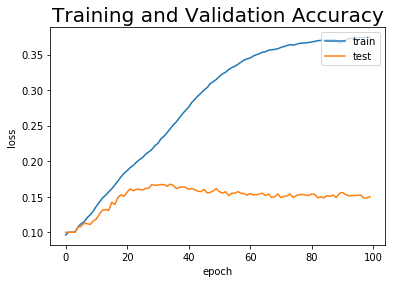

In [31]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Training and Validation Accuracy',size = 20)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [32]:
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu


## Average Bleu Score is 0.3724

## The Bilingual Evaluation Understudy Score, or BLEU for short, is a metric for evaluating a generated sentence to a reference sentence.

A perfect match results in a score of 1.0, whereas a perfect mismatch results in a score of 0.0.

The score was developed for evaluating the predictions made by automatic machine translation systems. It is not perfect, but does offer 5 compelling benefits:

It is quick and inexpensive to calculate.
It is easy to understand.
It is language independent.
It correlates highly with human evaluation.
It has been widely adopted.
The BLEU score was proposed by Kishore Papineni, et al. in their 2002 paper “BLEU: a Method for Automatic Evaluation of Machine Translation“.

Source: https://machinelearningmastery.com/calculate-bleu-score-for-text-python/#:~:text=Crash%2DCourse%20Now-,Bilingual%20Evaluation%20Understudy%20Score,in%20a%20score%20of%200.0.

# References.

* https://nextjournal.com/gkoehler/machine-translation-seq2seq-cpu?fbclid=IwAR2t0Ie4r68vPKvU-YHtWfkgJC7dmPSsbZCefwAW8aQe4RnE8qoCEYxGfoU
* https://arxiv.org/pdf/1508.04025.pdf
* https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

